In [78]:
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_visualization_tools as gvt
import pandas as pd
from multiprocessing import Pool
import numpy as np
from visual_behavior.data_access import loading, utilities, from_lims
import os
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
from visual_behavior_glm.glm import GLM
import seaborn as sns

import visual_behavior.utilities as vbu

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
versions = [
    '14_events_L2_optimize_by_session',
    '15_events_L2_optimize_by_session',
    '16_events_engaged_L2_optimize_by_session',
    '16_events_disengaged_L2_optimize_by_session',
    '16_events_all_L2_optimize_by_session'
]

In [5]:
results_raw = []
for version in versions:
    print('loading results for version {}'.format(version))
    results_raw.append(gat.retrieve_results({'glm_version': version}))
results_raw = pd.concat(results_raw, sort=True)

loading results for version 14_events_L2_optimize_by_session
loading results for version 15_events_L2_optimize_by_session
loading results for version 16_events_engaged_L2_optimize_by_session
loading results for version 16_events_disengaged_L2_optimize_by_session
loading results for version 16_events_all_L2_optimize_by_session


In [6]:
results_raw['session_type']

0        OPHYS_1_images_A
1        OPHYS_1_images_A
2        OPHYS_1_images_A
3        OPHYS_1_images_A
4        OPHYS_1_images_A
               ...       
61758    OPHYS_4_images_B
61759    OPHYS_4_images_B
61760    OPHYS_4_images_B
61761    OPHYS_4_images_B
61762    OPHYS_4_images_B
Name: session_type, Length: 326844, dtype: object

In [7]:
behavior_table = loading.get_behavior_model_summary_table()

In [8]:
results = results_raw.merge(
    behavior_table,
    left_on = 'behavior_session_id',
    right_on = 'behavior_session_id',
    how = 'left',
    suffixes = ['', '_duplicated']
)

In [9]:
results['session_type']

0         OPHYS_1_images_A
1         OPHYS_1_images_A
2         OPHYS_1_images_A
3         OPHYS_1_images_A
4         OPHYS_1_images_A
                ...       
326839    OPHYS_4_images_B
326840    OPHYS_4_images_B
326841    OPHYS_4_images_B
326842    OPHYS_4_images_B
326843    OPHYS_4_images_B
Name: session_type, Length: 326844, dtype: object

In [10]:
len(results)

326844

In [12]:
indices = [
    'ophys_experiment_id',
    'behavior_session_id',
    'session_type',
    'fraction_engaged',
    'glm_version',
]

results.groupby(['ophys_experiment_id','glm_version'])[['Full__avg_cv_var_test']].mean().reset_index().merge(
    results[['ophys_experiment_id','behavior_session_id','session_type','glm_version']],
    left_on = ['ophys_experiment_id', 'glm_version'],
    right_on = ['ophys_experiment_id', 'glm_version'],
    how='left'
).merge(
    behavior_table[['behavior_session_id','fraction_engaged']],
    left_on = 'behavior_session_id',
    right_on = 'behavior_session_id',
).drop_duplicates(subset = ['ophys_experiment_id', 'glm_version']).sort_values(by=['fraction_engaged','ophys_experiment_id','glm_version']).set_index(indices)

Full__avg_cv_var_test
ophys_experiment_id behavior_session_id session_type     fraction_engaged glm_version                                                       
830093338           829578829           OPHYS_4_images_B 0.000000         14_events_L2_optimize_by_session                          0.003258
                                                                          15_events_L2_optimize_by_session                          0.006351
                                                                          16_events_all_L2_optimize_by_session                      0.004025
                                                                          16_events_disengaged_L2_optimize_by_session               0.004459
                                                                          16_events_engaged_L2_optimize_by_session                       NaN
...                                                                                                                                      ...
993344860           993275724           OPHYS_4_images_A 0.999166         14_events_L2_optimize_by_session                          0.035072
                                                                          15_events_L2_optimize_by_session                          0.037886
                                                                          16_events_all_L2_optimize_by_session                      0.036648
                                                                          16_events_disengaged_L2_optimize_by_session                    NaN
                                                                          16_events_engaged_L2_optimize_by_session                  0.026953

[3898 rows x 1 columns]

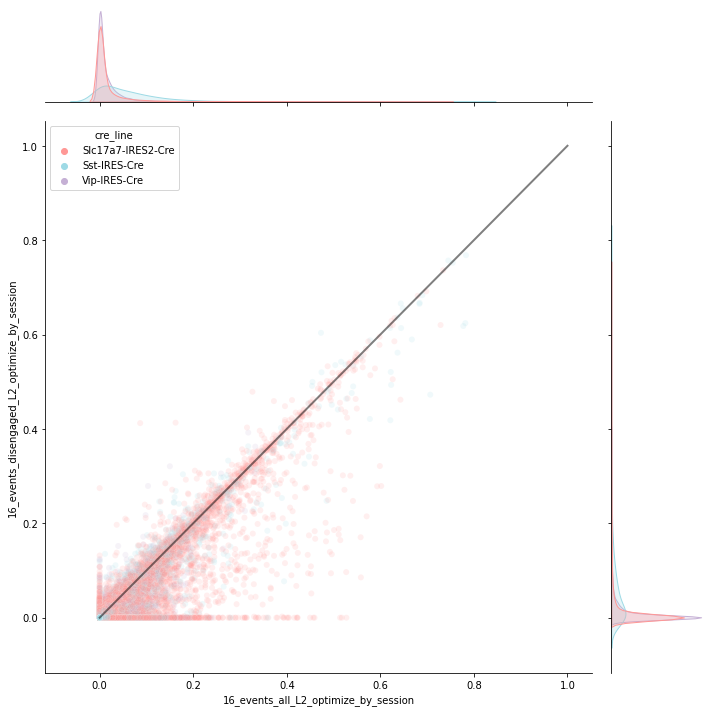

In [13]:
versions_to_compare=['16_events_all_L2_optimize_by_session', '16_events_disengaged_L2_optimize_by_session',]
gvt.plot_glm_version_comparison(versions_to_compare=versions_to_compare)

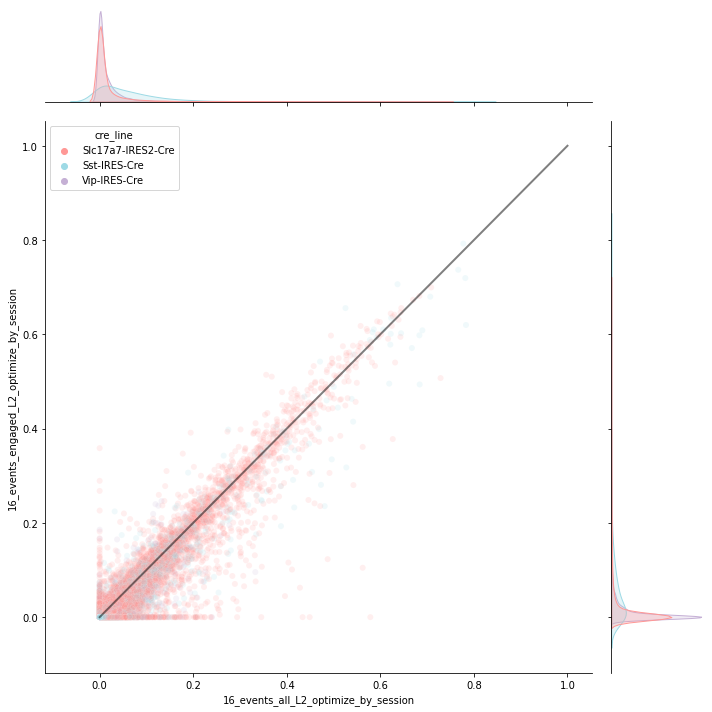

In [14]:
versions_to_compare=['16_events_all_L2_optimize_by_session', '16_events_engaged_L2_optimize_by_session', ]
gvt.plot_glm_version_comparison(versions_to_compare=versions_to_compare)

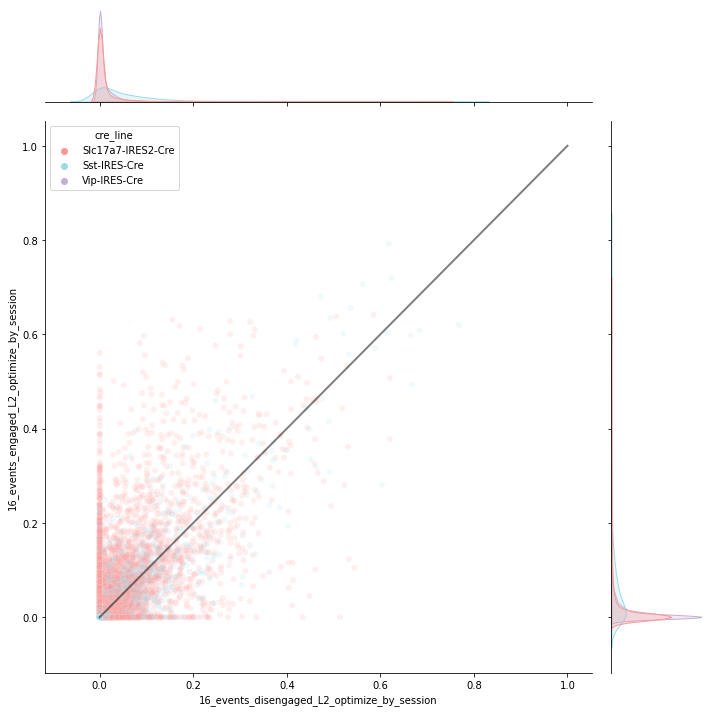

In [15]:
versions_to_compare=['16_events_disengaged_L2_optimize_by_session', '16_events_engaged_L2_optimize_by_session',]
gvt.plot_glm_version_comparison(versions_to_compare=versions_to_compare)

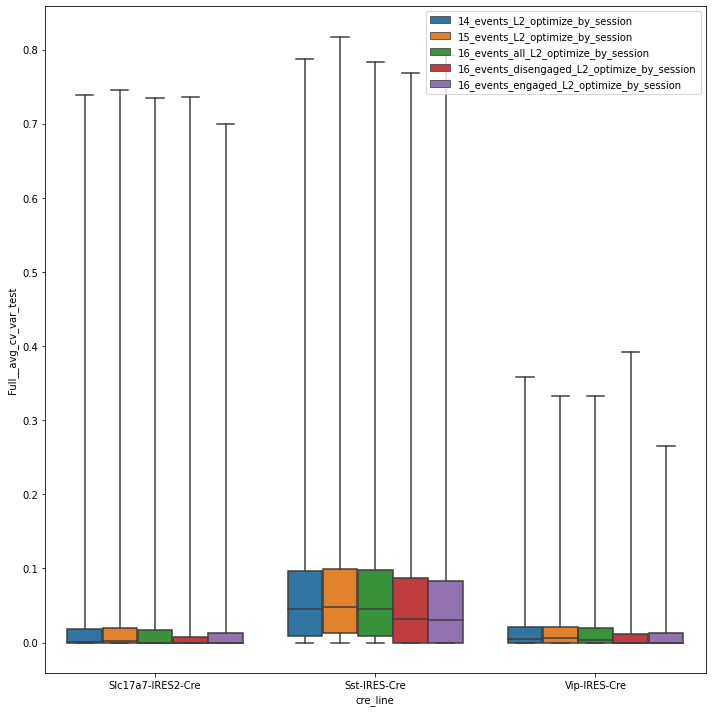

In [16]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.boxplot(
    data = results,
    x = 'cre_line',
    y = 'Full__avg_cv_var_test',
    hue = 'glm_version',
    order = np.sort(results['cre_line'].dropna().unique()),
    hue_order = np.sort(results['glm_version'].dropna().unique()),
    whis = np.inf,
)
plt.legend(loc='upper right')
fig.tight_layout()

In [17]:
results.groupby(['cre_line','glm_version'])['Full__avg_cv_var_test'].describe()

count  \
cre_line          glm_version                                            
Slc17a7-IRES2-Cre 14_events_L2_optimize_by_session             56318.0   
                  15_events_L2_optimize_by_session             56318.0   
                  16_events_all_L2_optimize_by_session         51805.0   
                  16_events_disengaged_L2_optimize_by_session  40609.0   
                  16_events_engaged_L2_optimize_by_session     36034.0   
Sst-IRES-Cre      14_events_L2_optimize_by_session              2666.0   
                  15_events_L2_optimize_by_session              2689.0   
                  16_events_all_L2_optimize_by_session          2689.0   
                  16_events_disengaged_L2_optimize_by_session   2163.0   
                  16_events_engaged_L2_optimize_by_session      1849.0   
Vip-IRES-Cre      14_events_L2_optimize_by_session              7241.0   
                  15_events_L2_optimize_by_session              7241.0   
                  16_events_all_L2_optimize_by_session          7241.0   
                  16_events_disengaged_L2_optimize_by_session   6022.0   
                  16_events_engaged_L2_optimize_by_session      4853.0   

                                                                   mean  \
cre_line          glm_version                                             
Slc17a7-IRES2-Cre 14_events_L2_optimize_by_session             0.025231   
                  15_events_L2_optimize_by_session             0.025898   
                  16_events_all_L2_optimize_by_session         0.024430   
                  16_events_disengaged_L2_optimize_by_session  0.017939   
                  16_events_engaged_L2_optimize_by_session     0.022321   
Sst-IRES-Cre      14_events_L2_optimize_by_session             0.074147   
                  15_events_L2_optimize_by_session             0.076581   
                  16_events_all_L2_optimize_by_session         0.074464   
                  16_events_disengaged_L2_optimize_by_session  0.064878   
                  16_events_engaged_L2_optimize_by_session     0.062816   
Vip-IRES-Cre      14_events_L2_optimize_by_session             0.016393   
                  15_events_L2_optimize_by_session             0.016869   
                  16_events_all_L2_optimize_by_session         0.016017   
                  16_events_disengaged_L2_optimize_by_session  0.011430   
                  16_events_engaged_L2_optimize_by_session     0.011587   

                                                                    std  min  \
cre_line          glm_version                                                  
Slc17a7-IRES2-Cre 14_events_L2_optimize_by_session             0.062909  0.0   
                  15_events_L2_optimize_by_session             0.063221  0.0   
                  16_events_all_L2_optimize_by_session         0.063038  0.0   
                  16_events_disengaged_L2_optimize_by_session  0.052802  0.0   
                  16_events_engaged_L2_optimize_by_session     0.061162  0.0   
Sst-IRES-Cre      14_events_L2_optimize_by_session             0.102256  0.0   
                  15_events_L2_optimize_by_session             0.102690  0.0   
                  16_events_all_L2_optimize_by_session         0.102996  0.0   
                  16_events_disengaged_L2_optimize_by_session  0.098840  0.0   
                  16_events_engaged_L2_optimize_by_session     0.097583  0.0   
Vip-IRES-Cre      14_events_L2_optimize_by_session             0.028173  0.0   
                  15_events_L2_optimize_by_session             0.028572  0.0   
                  16_events_all_L2_optimize_by_session         0.029275  0.0   
                  16_events_disengaged_L2_optimize_by_session  0.026555  0.0   
                  16_events_engaged_L2_optimize_by_session     0.024912  0.0   

                                                                    25%  \
cre_line          glm_version                                             
Slc17a7-IRES2-Cre 1

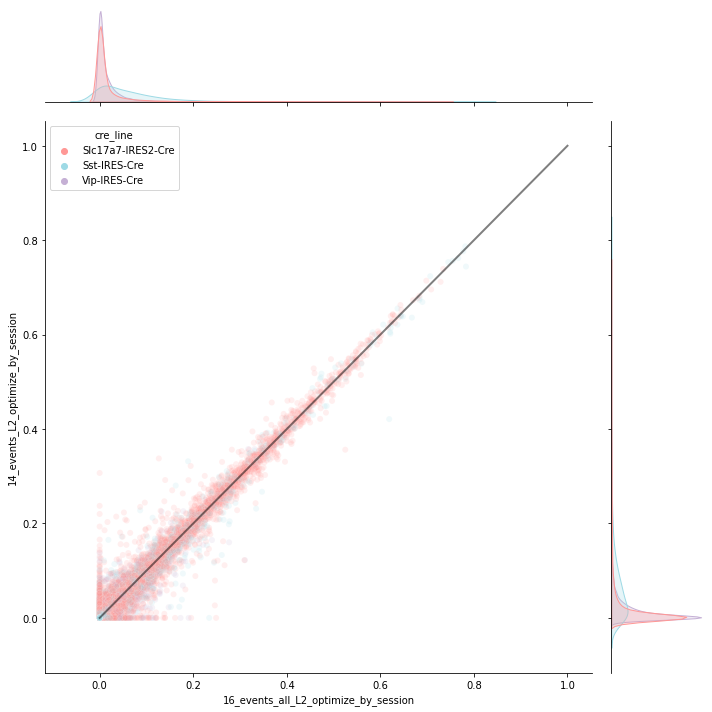

In [18]:
versions_to_compare=['16_events_all_L2_optimize_by_session', '14_events_L2_optimize_by_session',]
gvt.plot_glm_version_comparison(versions_to_compare=versions_to_compare)

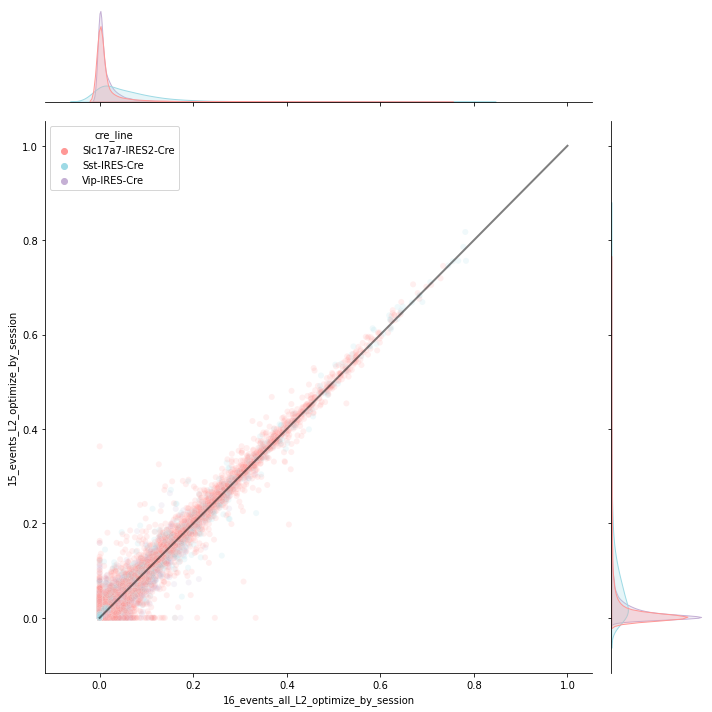

In [19]:
versions_to_compare=['16_events_all_L2_optimize_by_session', '15_events_L2_optimize_by_session',]
gvt.plot_glm_version_comparison(versions_to_compare=versions_to_compare)

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/visual_behavior_glm/visual_behavior_glm/GLM_analysis_tools.py:536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['identifier'] = results.apply(make_identifier, axis=1)


CPU times: user 18.3 s, sys: 6.08 s, total: 24.4 s
Wall time: 15.7 s


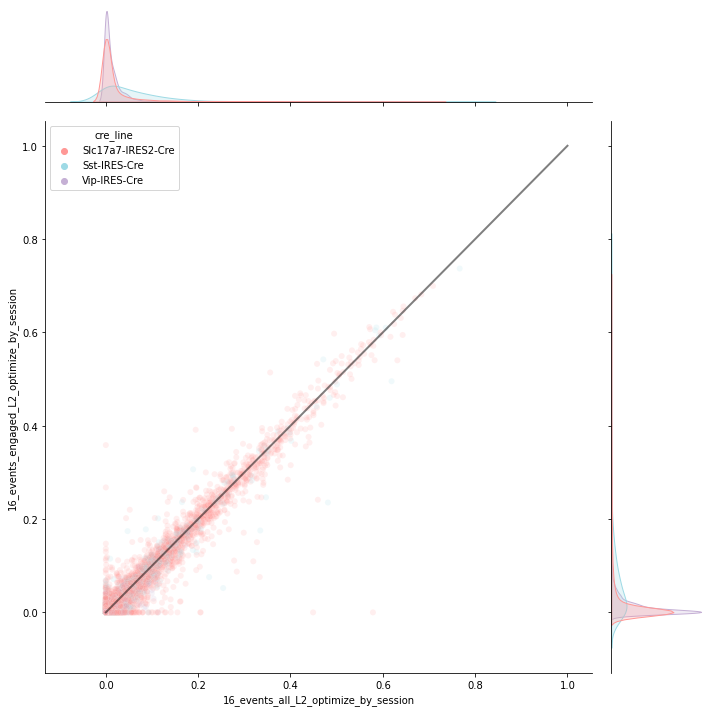

In [20]:
%%time
versions_to_compare=['16_events_all_L2_optimize_by_session', '16_events_engaged_L2_optimize_by_session', ]
jp = gvt.plot_glm_version_comparison(
    results=results.query('fraction_engaged > 0.75'), 
    versions_to_compare=versions_to_compare
)

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/visual_behavior_glm/visual_behavior_glm/GLM_analysis_tools.py:536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['identifier'] = results.apply(make_identifier, axis=1)


CPU times: user 3.24 s, sys: 338 ms, total: 3.58 s
Wall time: 3.36 s


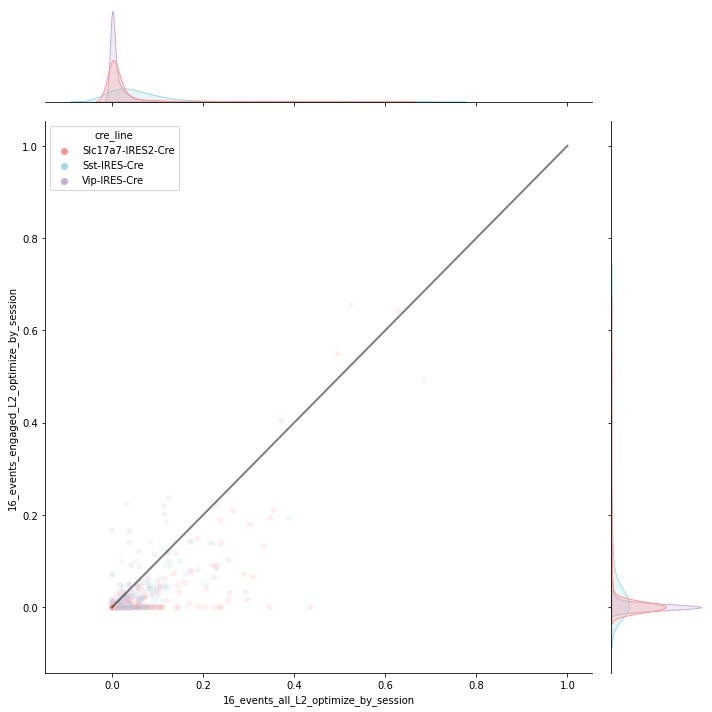

In [21]:
%%time
versions_to_compare=['16_events_all_L2_optimize_by_session', '16_events_engaged_L2_optimize_by_session', ]
jp = gvt.plot_glm_version_comparison(
    results=results.query('fraction_engaged < 0.25'), 
    versions_to_compare=versions_to_compare
)

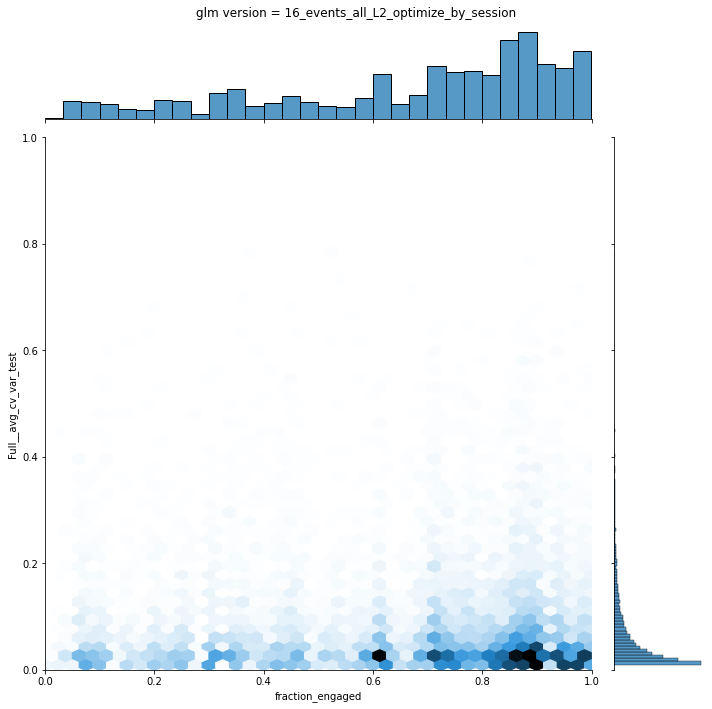

In [22]:
glm_version = "16_events_all_L2_optimize_by_session"
jointplot = sns.jointplot(
    data = results.query('glm_version == @glm_version').dropna(subset = ['fraction_engaged']).query('Full__avg_cv_var_test > 0.01'),
    x = 'fraction_engaged',
    y = 'Full__avg_cv_var_test',
    kind = 'hex',
    height = 10,
)
jointplot.fig.suptitle('glm version = {}'.format(glm_version))
jointplot.ax_joint.set_xlim(0,1)
jointplot.ax_joint.set_ylim(0,1)
jointplot.fig.tight_layout()

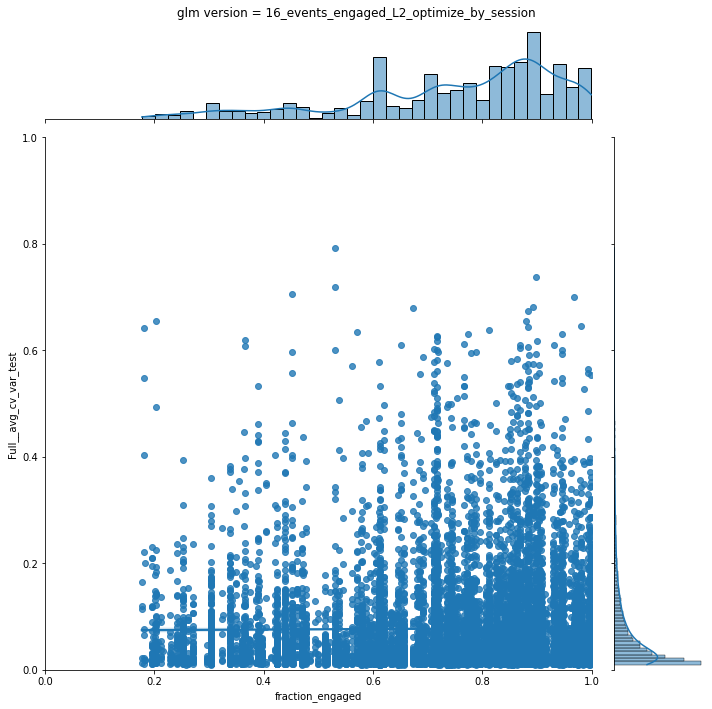

In [23]:
glm_version = "16_events_engaged_L2_optimize_by_session"
jointplot = sns.jointplot(
    data = results.query('glm_version == @glm_version').dropna(subset = ['fraction_engaged']).query('Full__avg_cv_var_test > 0.01'),
    x = 'fraction_engaged',
    y = 'Full__avg_cv_var_test',
    kind = 'reg',
    height = 10,
)
jointplot.fig.suptitle('glm version = {}'.format(glm_version))
jointplot.ax_joint.set_xlim(0,1)
jointplot.ax_joint.set_ylim(0,1)
jointplot.fig.tight_layout()

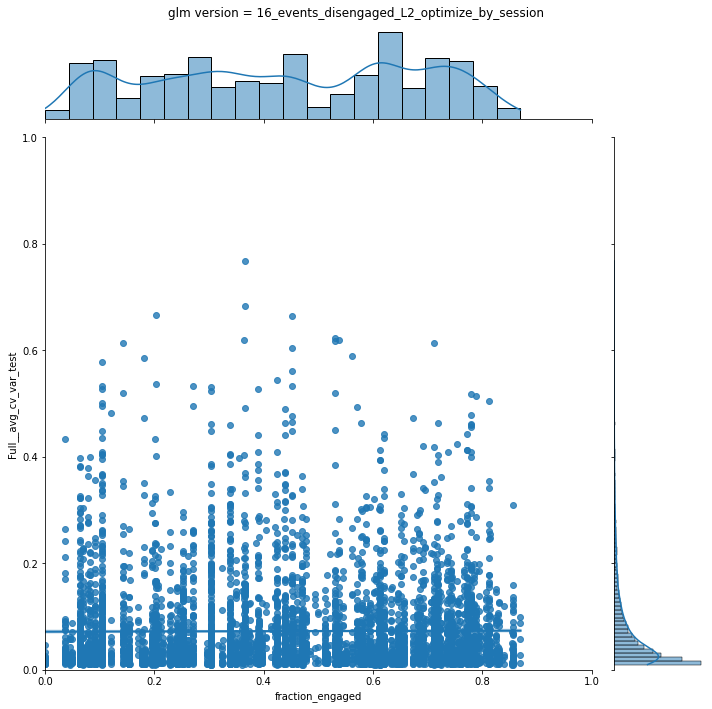

In [24]:
glm_version = "16_events_disengaged_L2_optimize_by_session"
jointplot = sns.jointplot(
    data = results.query('glm_version == @glm_version').dropna(subset = ['fraction_engaged']).query('Full__avg_cv_var_test > 0.01'),
    x = 'fraction_engaged',
    y = 'Full__avg_cv_var_test',
    kind = 'reg',
    height = 10,
)
jointplot.ax_joint.set_xlim(0,1)
jointplot.ax_joint.set_ylim(0,1)
jointplot.fig.suptitle('glm version = {}'.format(glm_version))
jointplot.fig.tight_layout()

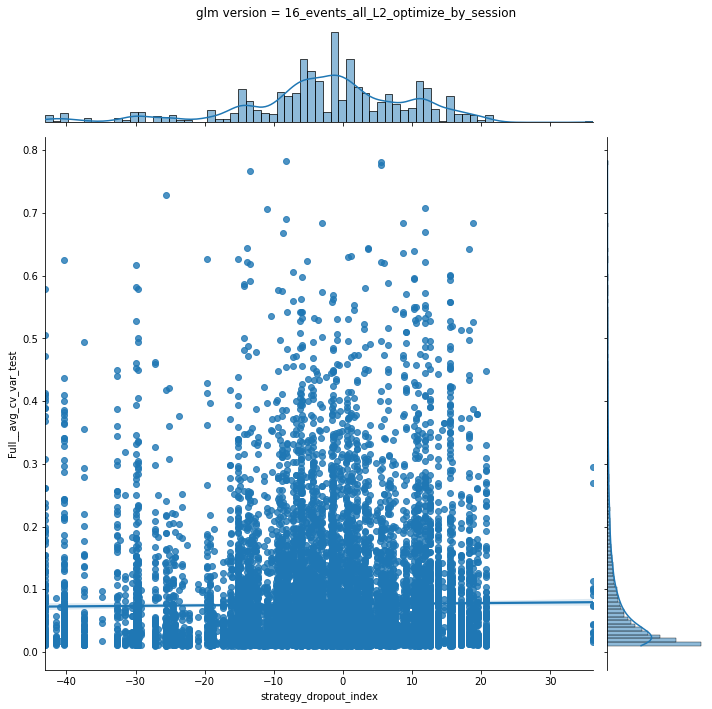

In [25]:
glm_version = "16_events_all_L2_optimize_by_session"
jointplot = sns.jointplot(
    data = results.query('glm_version == @glm_version').dropna(subset = ['fraction_engaged']).query('Full__avg_cv_var_test > 0.01'),
    x = 'strategy_dropout_index',
    y = 'Full__avg_cv_var_test',
    kind = 'reg',
    height = 10,
)
jointplot.fig.suptitle('glm version = {}'.format(glm_version))
jointplot.fig.tight_layout()

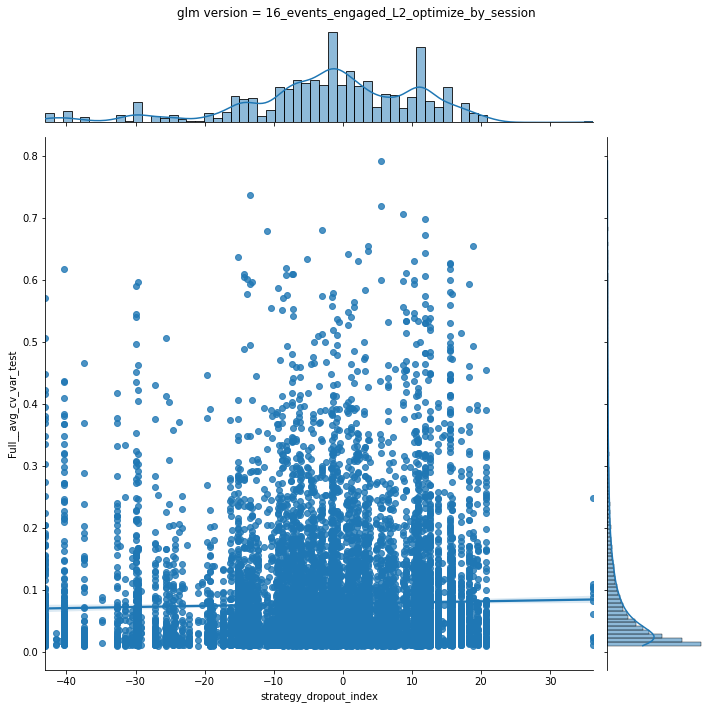

In [26]:
glm_version = "16_events_engaged_L2_optimize_by_session"
jointplot = sns.jointplot(
    data = results.query('glm_version == @glm_version').dropna(subset = ['fraction_engaged']).query('Full__avg_cv_var_test > 0.01'),
    x = 'strategy_dropout_index',
    y = 'Full__avg_cv_var_test',
    kind = 'reg',
    height = 10,
)
jointplot.fig.suptitle('glm version = {}'.format(glm_version))
jointplot.fig.tight_layout()

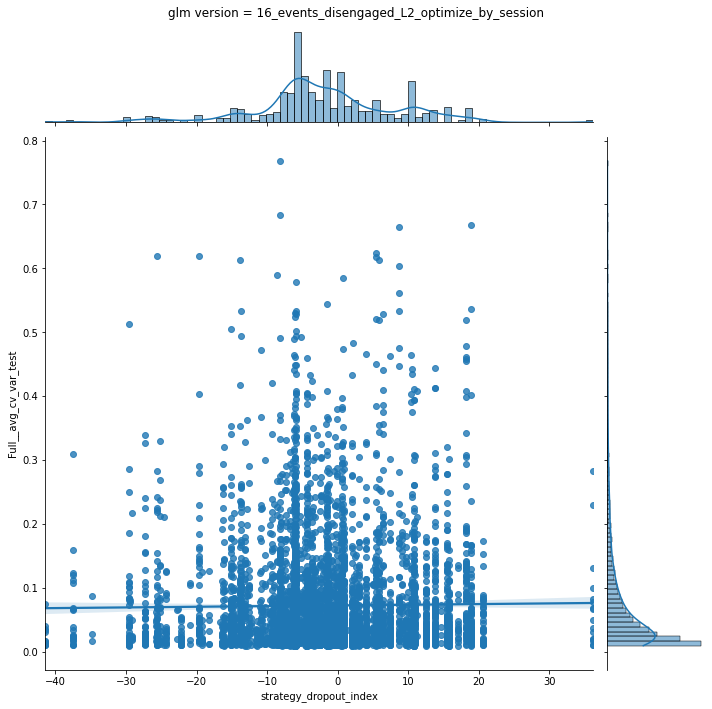

In [27]:
glm_version = "16_events_disengaged_L2_optimize_by_session"
jointplot = sns.jointplot(
    data = results.query('glm_version == @glm_version').dropna(subset = ['fraction_engaged']).query('Full__avg_cv_var_test > 0.01'),
    x = 'strategy_dropout_index',
    y = 'Full__avg_cv_var_test',
    kind = 'reg',
    height = 10,
)
jointplot.fig.suptitle('glm version = {}'.format(glm_version))
jointplot.fig.tight_layout()

In [28]:
versions_to_compare = ["16_events_engaged_L2_optimize_by_session" , "16_events_disengaged_L2_optimize_by_session"]
version_comparison = gat.get_glm_version_comparison_table(
    versions_to_compare = versions_to_compare,
    results=results.query('glm_version in @versions_to_compare'), 
    metric='Full__avg_cv_var_test'
).rename(columns = {"16_events_engaged_L2_optimize_by_session": "v16_events_engaged_L2_optimize_by_session" , "16_events_disengaged_L2_optimize_by_session":"v16_events_disengaged_L2_optimize_by_session"})

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/visual_behavior_glm/visual_behavior_glm/GLM_analysis_tools.py:536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['identifier'] = results.apply(make_identifier, axis=1)


In [29]:
sample_cell = version_comparison.query('{0} > {1} and {1} > 0.5'.format('v16_events_engaged_L2_optimize_by_session', 'v16_events_disengaged_L2_optimize_by_session')).sample(random_state=1).iloc[0]
sample_cell

identifier                                      959337328_1086505751
v16_events_disengaged_L2_optimize_by_session                0.585607
v16_events_engaged_L2_optimize_by_session                   0.641648
age_in_days                                                      126
behavior_session_id                                        958888268
                                                        ...         
lick_bout_rate_disengaged                                  0.0342828
reward_rate_engaged                                        0.0369831
reward_rate_disengaged                                    0.00144745
RT_engaged                                                  0.396631
RT_disengaged                                               0.254967
Name: 46655, Length: 138, dtype: object

In [133]:
sample_cell['v16_events_engaged_L2_optimize_by_session']

0.6416479208946491

In [134]:
sample_cell['v16_events_disengaged_L2_optimize_by_session']

0.5856073001639897

In [30]:
print(sample_cell['ophys_experiment_id'], sample_cell['cell_specimen_id'])

959337328 1086505751


In [41]:
models = {}
for version in ["16_events_engaged_L2_optimize_by_session" , "16_events_disengaged_L2_optimize_by_session", "16_events_all_L2_optimize_by_session"]:
    models[version] = GLM(
        ophys_experiment_id = sample_cell['ophys_experiment_id'],
        version = version, 
        log_results=False, 
        log_weights=False,
        use_previous_fit=True,
        NO_DROPOUTS=True,
    )

importing GLM_fit_tools from /allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_engaged_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py
loading previous fit...
    Adding kernel: intercept
    Adding kernel: time
    Adding kernel: licks


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: passive_change
	Error encountered while adding kernel for passive_change. Attemping to continue without this kernel.
	Passive Change kernel cant be added to active sessions


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/behavior/metadata/behavior_metadata.py:226: UserWarning: The `date_of_acquisition` field in LIMS (2019-10-01 15:38:30+00:00) for behavior session (958888268) deviates by more than an hour from the `start_time` (2019-10-01 08:58:49.527000+00:00) specified in the associated stimulus *.pkl file: /allen/programs/braintv/production/visualbehavior/prod3/specimen_912554454/behavior_session_958888268/958774480.pkl
  warnings.warn(


    Adding kernel: false_alarms
	Error encountered while adding kernel for false_alarms. Attemping to continue without this kernel.
	Less than minimum number of events: 3 false_alarm
    Adding kernel: correct_rejects
    Adding kernel: omissions
    Adding kernel: running
                 : Normalized by max value: 100
    Adding kernel: pupil


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_engaged_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:796: RuntimeWarning: invalid value encountered in greater
  d_mask = np.abs(np.diff(x,append=x[-1])) > run_params['eye_transient_threshold']
/home/dougo/anaconda3/envs/vba/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:702: Run

                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: face_motion_PC_0
could not load PC activations for ophys_session_id 958774480
list index out of range
could not load PC activations for ophys_session_id 958774480
list index out of range
	Error encountered while adding kernel for face_motion_PC_0. Attemping to continue without this kernel. 
list indices must be integers or slices, not tuple
    Adding kernel: face_motion_PC_1
could not load PC activations for ophys_session_id 958774480
list index out of range
could not load PC activations for ophys_session_id 958774480
list index out of range
	Error encountered while adding kernel for face_motion_PC_1. Attemping to continue without this kernel. 
list indices must be integers or slices, not tuple
    Adding kernel: face_motion_PC_2
could not load PC activations for ophys_session_id 958774480
list index out of range
could not load PC activations for ophys_session_id 958774480
list index 

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


Using detected events instead of df/f


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/behavior/metadata/behavior_metadata.py:226: UserWarning: The `date_of_acquisition` field in LIMS (2019-10-01 15:38:30+00:00) for behavior session (958888268) deviates by more than an hour from the `start_time` (2019-10-01 08:58:49.527000+00:00) specified in the associated stimulus *.pkl file: /allen/programs/braintv/production/visualbehavior/prod3/specimen_912554454/behavior_session_958888268/958774480.pkl
  warnings.warn(


Adding Engagement labels. Preferred engagement state: engaged
	% of session engaged:    0.18729366293582414
	% of session disengaged: 0.8127063370641758
Build Design Matrix
    Adding kernel: intercept
    Adding kernel: time
    Adding kernel: licks
    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: correct_rejects
    Adding kernel: omissions
    Adding kernel: running
                 : Normalized by max value: 100
    Adding kernel: pupil


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_engaged_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:796: RuntimeWarning: invalid value encountered in greater
  d_mask = np.abs(np.diff(x,append=x[-1])) > run_params['eye_transient_threshold']
/home/dougo/anaconda3/envs/vba/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:702: Run

                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
    Adding kernel: model_bias
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: model_task0
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: model_omissions1
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: model_timing1D
                 : Mean Centering
                 : Standardized to unit variance
Splitting fit dictionary entries by engagement


    Fitting L2, 0.1:   0%|          | 0/5 [00:00<?, ?it/s]

Trimming Design Matrix by engagement
Setting up CV
Evaluating Regularization values
Evaluating a grid of regularization values


    Fitting L2, 500.0: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Setting up model selection dropout
Iterating over model selection
Using a constant regularization value across all cells


    Fitting model, Full: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


Saving results
Saving Events Table
Finished
done fitting model, collecting results


/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_engaged_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:648: RuntimeWarning: Mean of empty slice
  results[model_label+"__avg_cv_adjvar_train"] = np.nanmean(fit['dropouts'][model_label]['cv_adjvar_train'],1)
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_engaged_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:649: RuntimeWarning: Mean of empty slice
  results[model_label+"__avg_cv_adjvar_test"]  = np.nanmean(fit['dropouts'][model_label]['cv_adjvar_test'],1)
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_engaged_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:650: RuntimeWarning: Mean of empty slice
  results[model_label+"__avg_cv_adjvar_test_full_comparison"]  = np.nanmean(fit['dropouts'][model_label]['cv_adjvar_test_full_comparison'],1)


done collecting results
done building GLM object
importing GLM_fit_tools from /allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_disengaged_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py
loading previous fit...
    Adding kernel: intercept
    Adding kernel: time
    Adding kernel: licks


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: passive_change
	Error encountered while adding kernel for passive_change. Attemping to continue without this kernel.
	Passive Change kernel cant be added to active sessions


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/behavior/metadata/behavior_metadata.py:226: UserWarning: The `date_of_acquisition` field in LIMS (2019-10-01 15:38:30+00:00) for behavior session (958888268) deviates by more than an hour from the `start_time` (2019-10-01 08:58:49.527000+00:00) specified in the associated stimulus *.pkl file: /allen/programs/braintv/production/visualbehavior/prod3/specimen_912554454/behavior_session_958888268/958774480.pkl
  warnings.warn(


    Adding kernel: false_alarms
	Error encountered while adding kernel for false_alarms. Attemping to continue without this kernel.
	Less than minimum number of events: 3 false_alarm
    Adding kernel: correct_rejects
    Adding kernel: omissions
    Adding kernel: running
                 : Normalized by max value: 100
    Adding kernel: pupil


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_disengaged_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:796: RuntimeWarning: invalid value encountered in greater
  d_mask = np.abs(np.diff(x,append=x[-1])) > run_params['eye_transient_threshold']
/home/dougo/anaconda3/envs/vba/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:702: 

                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: face_motion_PC_0
could not load PC activations for ophys_session_id 958774480
list index out of range
could not load PC activations for ophys_session_id 958774480
list index out of range
	Error encountered while adding kernel for face_motion_PC_0. Attemping to continue without this kernel. 
list indices must be integers or slices, not tuple
    Adding kernel: face_motion_PC_1
could not load PC activations for ophys_session_id 958774480
list index out of range
could not load PC activations for ophys_session_id 958774480
list index out of range
	Error encountered while adding kernel for face_motion_PC_1. Attemping to continue without this kernel. 
list indices must be integers or slices, not tuple
    Adding kernel: face_motion_PC_2
could not load PC activations for ophys_session_id 958774480
list index out of range
could not load PC activations for ophys_session_id 958774480
list index 

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


Using detected events instead of df/f


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/behavior/metadata/behavior_metadata.py:226: UserWarning: The `date_of_acquisition` field in LIMS (2019-10-01 15:38:30+00:00) for behavior session (958888268) deviates by more than an hour from the `start_time` (2019-10-01 08:58:49.527000+00:00) specified in the associated stimulus *.pkl file: /allen/programs/braintv/production/visualbehavior/prod3/specimen_912554454/behavior_session_958888268/958774480.pkl
  warnings.warn(


Adding Engagement labels. Preferred engagement state: disengaged
	% of session engaged:    0.18729366293582414
	% of session disengaged: 0.8127063370641758
Build Design Matrix
    Adding kernel: intercept
    Adding kernel: time
    Adding kernel: licks
    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: correct_rejects
    Adding kernel: omissions
    Adding kernel: running
                 : Normalized by max value: 100
    Adding kernel: pupil


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_disengaged_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:796: RuntimeWarning: invalid value encountered in greater
  d_mask = np.abs(np.diff(x,append=x[-1])) > run_params['eye_transient_threshold']
/home/dougo/anaconda3/envs/vba/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:702: 

                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: image0
    Adding kernel: image1
    Adding kernel: image2
    Adding kernel: image3
    Adding kernel: image4
    Adding kernel: image5
    Adding kernel: image6
    Adding kernel: image7
    Adding kernel: model_bias
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: model_task0
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: model_omissions1
                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: model_timing1D
                 : Mean Centering
                 : Standardized to unit variance
Splitting fit dictionary entries by engagement
Trimming Design Matrix by engagement
Setting up CV
Evaluating Regularization values
Evaluating a grid of regularization values


    Fitting L2, 500.0: 100%|██████████| 5/5 [00:34<00:00,  6.91s/it]


Setting up model selection dropout
Iterating over model selection
Using a constant regularization value across all cells


    Fitting model, Full: 100%|██████████| 5/5 [01:45<00:00, 21.04s/it]


Saving results
Saving Events Table
Finished
done fitting model, collecting results


/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_disengaged_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:648: RuntimeWarning: Mean of empty slice
  results[model_label+"__avg_cv_adjvar_train"] = np.nanmean(fit['dropouts'][model_label]['cv_adjvar_train'],1)
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_disengaged_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:649: RuntimeWarning: Mean of empty slice
  results[model_label+"__avg_cv_adjvar_test"]  = np.nanmean(fit['dropouts'][model_label]['cv_adjvar_test'],1)
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_disengaged_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:650: RuntimeWarning: Mean of empty slice
  results[model_label+"__avg_cv_adjvar_test_full_comparison"]  = np.nanmean(fit['dropouts'][model_label]['cv_adjvar_test_full_comparison'],1)


done collecting results
done building GLM object
importing GLM_fit_tools from /allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_all_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py
loading previous fit...
    Adding kernel: intercept
    Adding kernel: time
    Adding kernel: licks


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


    Adding kernel: hits
    Adding kernel: misses
    Adding kernel: passive_change
	Error encountered while adding kernel for passive_change. Attemping to continue without this kernel.
	Passive Change kernel cant be added to active sessions


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/behavior/metadata/behavior_metadata.py:226: UserWarning: The `date_of_acquisition` field in LIMS (2019-10-01 15:38:30+00:00) for behavior session (958888268) deviates by more than an hour from the `start_time` (2019-10-01 08:58:49.527000+00:00) specified in the associated stimulus *.pkl file: /allen/programs/braintv/production/visualbehavior/prod3/specimen_912554454/behavior_session_958888268/958774480.pkl
  warnings.warn(


    Adding kernel: false_alarms
	Error encountered while adding kernel for false_alarms. Attemping to continue without this kernel.
	Less than minimum number of events: 3 false_alarm
    Adding kernel: correct_rejects
    Adding kernel: omissions
    Adding kernel: running
                 : Normalized by max value: 100
    Adding kernel: pupil


/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_all_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:795: RuntimeWarning: invalid value encountered in greater
  d_mask = np.abs(np.diff(x,append=x[-1])) > run_params['eye_transient_threshold']
/home/dougo/anaconda3/envs/vba/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:702: Runtime

                 : Mean Centering
                 : Standardized to unit variance
    Adding kernel: face_motion_PC_0
could not load PC activations for ophys_session_id 958774480
list index out of range
could not load PC activations for ophys_session_id 958774480
list index out of range
	Error encountered while adding kernel for face_motion_PC_0. Attemping to continue without this kernel. 
list indices must be integers or slices, not tuple
    Adding kernel: face_motion_PC_1
could not load PC activations for ophys_session_id 958774480
list index out of range
could not load PC activations for ophys_session_id 958774480
list index out of range
	Error encountered while adding kernel for face_motion_PC_1. Attemping to continue without this kernel. 
list indices must be integers or slices, not tuple
    Adding kernel: face_motion_PC_2
could not load PC activations for ophys_session_id 958774480
list index out of range
could not load PC activations for ophys_session_id 958774480
list index 

/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_all_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:647: RuntimeWarning: Mean of empty slice
  results[model_label+"__avg_cv_adjvar_train"] = np.nanmean(fit['dropouts'][model_label]['cv_adjvar_train'],1)
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_all_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:648: RuntimeWarning: Mean of empty slice
  results[model_label+"__avg_cv_adjvar_test"]  = np.nanmean(fit['dropouts'][model_label]['cv_adjvar_test'],1)
/allen/programs/braintv/workgroups/nc-ophys/visual_behavior/ophys_glm/v_16_events_all_L2_optimize_by_session/frozen_model_files/GLM_fit_tools.py:649: RuntimeWarning: Mean of empty slice
  results[model_label+"__avg_cv_adjvar_test_full_comparison"]  = np.nanmean(fit['dropouts'][model_label]['cv_adjvar_test_full_comparison'],1)


done collecting results
done building GLM object


In [42]:
sample_cell['cell_specimen_id']

1086505751

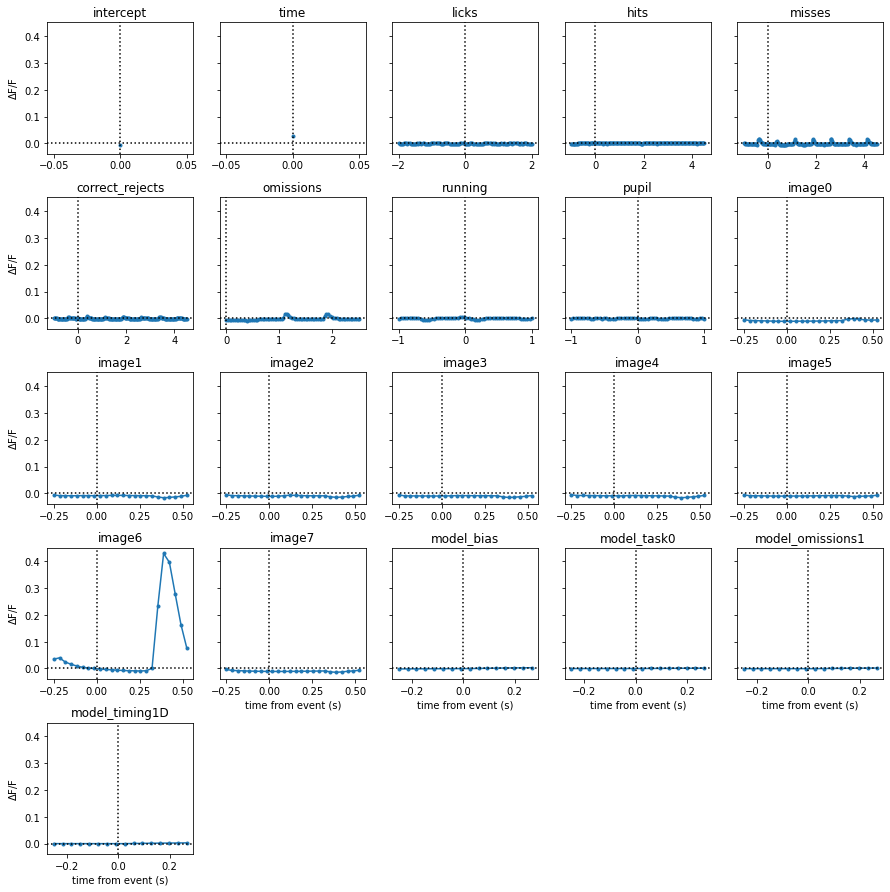

In [43]:
models['16_events_all_L2_optimize_by_session'].plot_filters(sample_cell['cell_specimen_id'])

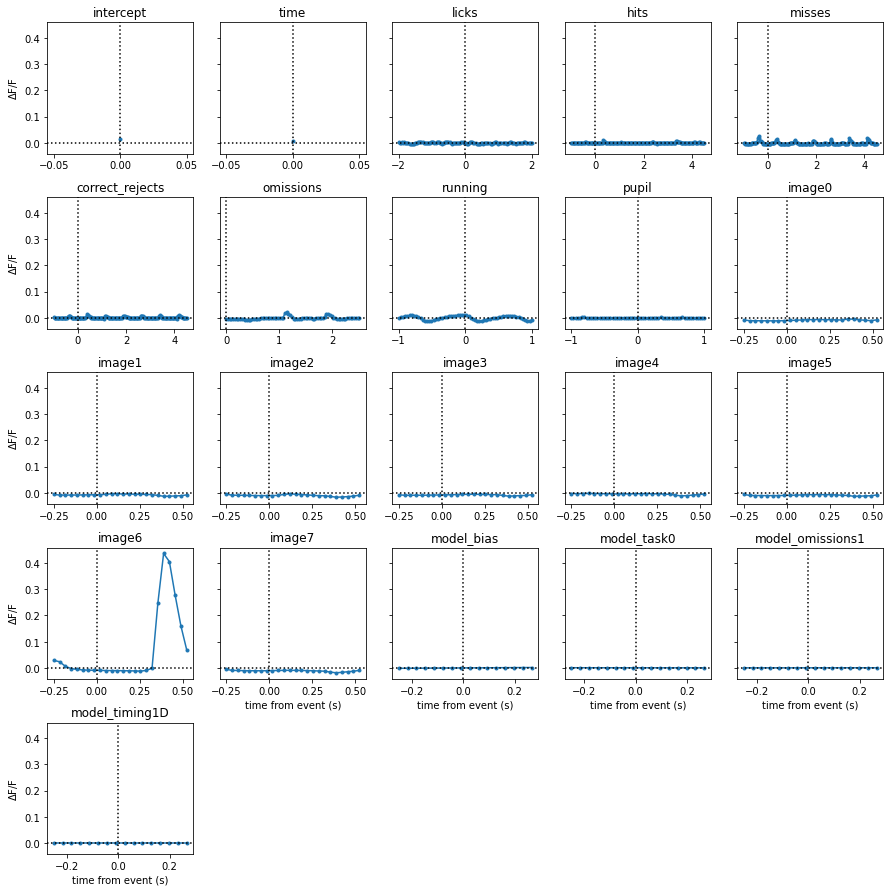

In [44]:
models['16_events_engaged_L2_optimize_by_session'].plot_filters(sample_cell['cell_specimen_id'])

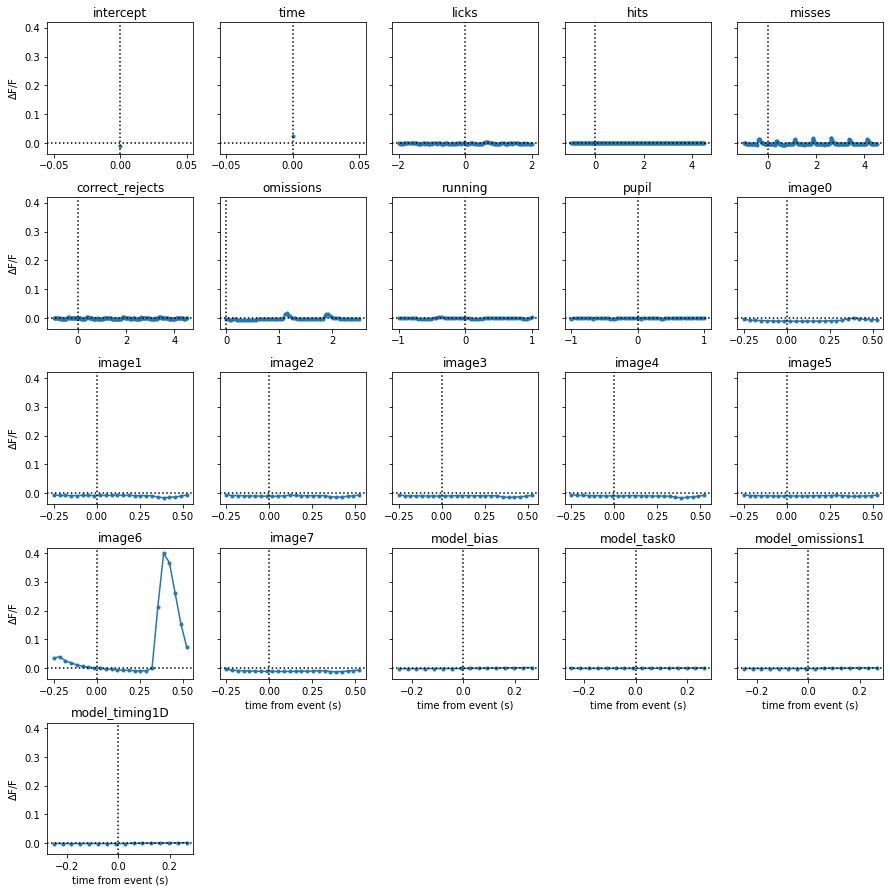

In [45]:
models['16_events_disengaged_L2_optimize_by_session'].plot_filters(sample_cell['cell_specimen_id'])

In [48]:
dataset = loading.get_ophys_dataset(sample_cell['ophys_experiment_id'])
neural_data = utilities.build_tidy_cell_df(dataset)

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/sync_dataset.py:109: UserWarning: The loaded sync file contains the following deprecated line label keys: {'cam2_exposure', 'cam1_exposure'}. Consider updating the sync file line labels.
  self._check_line_labels()


In [51]:
behavior_session_id = from_lims.get_behavior_session_id_for_ophys_experiment_id(sample_cell['ophys_experiment_id'])
behavior_model_df = loading.load_behavior_model_outputs(behavior_session_id)
behavior_model_df

,stimulus_presentations_id,lick_bout_start,lick_bout_end,lick_bout_rate,rewarded_lick_bout,lick_hit_fraction,hit_rate,miss_rate,false_alarm_rate,correct_reject_rate,d_prime,criterion,RT,engaged,in_lick_bout,bias,omissions,omissions1,task0,timing1D
0,0,False,False,0.000000,NaN,0.0,0.0,0.0,0.000000,1.000000,0.000000,-2.326348,NaN,False,0,-1.882305,-0.554343,0.126921,0.963622,0.702572
1,1,True,True,0.333333,0.0,0.0,0.0,0.0,0.250000,0.750000,-1.651858,-1.500419,0.166765,False,0,-1.881407,-0.554357,0.126912,0.963618,0.702501
2,2,False,False,0.444444,0.0,0.0,0.0,0.0,0.333333,0.666667,-1.895621,-1.378538,0.166765,False,0,-1.893453,-0.554266,0.127038,0.963831,0.703391
3,3,False,False,0.416667,0.0,0.0,0.0,0.0,0.312500,0.687500,-1.837571,-1.407562,0.166765,False,0,-1.904510,-0.554182,0.127154,0.964027,0.704208
4,4,False,False,0.373333,0.0,0.0,0.0,0.0,0.280000,0.720000,-1.743506,-1.454595,0.166765,False,0,-1.914975,-0.553985,0.127264,0.964213,0.704983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4806,4806,False,False,0.046016,0.0,0.0,0.0,1.0,0.036897,0.963103,-0.538460,-2.057118,0.483731,False,0,-4.434605,-1.853360,0.116107,-0.834137,-0.619795
4807,4807,False,False,0.045443,0.0,0.0,0.0,1.0,0.036439,0.963561,-0.532756,-2.059970,0.483731,False,0,-4.435175,-1.853361,0.116062,-0.834128,-0.619800
4808,4808,False,False,0.044896,0.0,0.0,0.0,1.0,0.036001,0.963999,-0.527238,-2.062729,0.483731,False,0,-4.435571,-1.853363,0.116016,-0.834121,-0.619804
4809,4809,False,False,0.044401,0.0,0.0,0.0,1.0,0.035604,0.964396,-0.522198,-2.065249,0.483731,False,0,-4.435793,-1.853367,0.115968,-0.834117,-0.619806


In [58]:
stim_df = dataset.stimulus_presentations.merge(
    behavior_model_df,
    left_on = 'stimulus_presentations_id',
    right_on = 'stimulus_presentations_id'
)
stim_df

,stimulus_presentations_id,duration,end_frame,image_index,image_name,image_set,index,is_change,omitted,start_frame,start_time,stop_time,lick_bout_start,lick_bout_end,lick_bout_rate,rewarded_lick_bout,lick_hit_fraction,hit_rate,miss_rate,false_alarm_rate,correct_reject_rate,d_prime,criterion,RT,engaged,in_lick_bout,bias,omissions,omissions1,task0,timing1D
0,0,0.25023,18001.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,0,False,False,17986,307.82611,308.07634,False,False,0.000000,NaN,0.0,0.0,0.0,0.000000,1.000000,0.000000,-2.326348,NaN,False,0,-1.882305,-0.554343,0.126921,0.963622,0.702572
1,1,0.25020,18046.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,1,False,False,18031,308.57674,308.82694,True,True,0.333333,0.0,0.0,0.0,0.0,0.250000,0.750000,-1.651858,-1.500419,0.166765,False,0,-1.881407,-0.554357,0.126912,0.963618,0.702501
2,2,0.25020,18091.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,2,False,False,18076,309.32735,309.57755,False,False,0.444444,0.0,0.0,0.0,0.0,0.333333,0.666667,-1.895621,-1.378538,0.166765,False,0,-1.893453,-0.554266,0.127038,0.963831,0.703391
3,3,NaN,NaN,8,omitted,omitted,0,False,True,18120,310.06129,NaN,False,False,0.416667,0.0,0.0,0.0,0.0,0.312500,0.687500,-1.837571,-1.407562,0.166765,False,0,-1.904510,-0.554182,0.127154,0.964027,0.704208
4,4,0.25018,18181.0,0,im000,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,3,False,False,18166,310.82860,311.07878,False,False,0.373333,0.0,0.0,0.0,0.0,0.280000,0.720000,-1.743506,-1.454595,0.166765,False,0,-1.914975,-0.553985,0.127264,0.964213,0.704983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4806,4806,0.25023,234271.0,6,im031,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4613,False,False,234256,3915.25987,3915.51010,False,False,0.046016,0.0,0.0,0.0,1.0,0.036897,0.963103,-0.538460,-2.057118,0.483731,False,0,-4.434605,-1.853360,0.116107,-0.834137,-0.619795
4807,4807,0.25017,234316.0,6,im031,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4614,False,False,234301,3916.01051,3916.26068,False,False,0.045443,0.0,0.0,0.0,1.0,0.036439,0.963561,-0.532756,-2.059970,0.483731,False,0,-4.435175,-1.853361,0.116062,-0.834128,-0.619800
4808,4808,0.25035,234361.0,6,im031,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14,4615,False,False,234346,3916.76109,3917.01144,False,False,0.044896,0.0,0.0,0.0,1.0,0.036001,0.963999,-0.527238,-2.062729,0.483731,False,0,-4.435571,-1.853363,0.116016,-0.834121,-0.619804
4809,4809,NaN,NaN,8,omitted,omitted,193,False,True,234390,3917.49503,NaN,False,False,0.044401,0.0,0.0,0.0,1.0,0.035604,0.964396,-0.522198,-2.065249,0.483731,False,0,-4.435793,-1.853367,0.115968,-0.834117,-0.619806


In [60]:
timestamp = 2.89564
behavior_model_index = np.abs(timestamp - stim_df['start_time']).idxmin()
behavior_model_index

0

In [63]:
engagement_df = pd.DataFrame({'timestamps': neural_data['timestamps'].unique()})
for idx, row in engagement_df.iterrows():
    nearest_behavior_index = np.abs(row['timestamps'] - stim_df['start_time']).idxmin()
    engagement_df.at[idx, 'engaged'] = stim_df.loc[nearest_behavior_index]['engaged']

In [64]:
engagement_df

,timestamps,engaged
0,2.89564,False
1,2.92794,False
2,2.96024,False
3,2.99255,False
4,3.02485,False
...,...,...
140415,4539.50599,False
140416,4539.53830,False
140417,4539.57061,False
140418,4539.60292,False


In [65]:
neural_data.merge(
    engagement_df,
    left_on = 'timestamps',
    right_on = 'timestamps',
)

,timestamps,cell_roi_id,cell_specimen_id,dff,events,filtered_events,engaged
0,2.89564,1080754962,1086505286,0.256223,0.000000,0.000000,False
1,2.89564,1080754999,1086538151,0.289764,0.000000,0.000000,False
2,2.89564,1080755006,1086497902,0.207747,0.000000,0.000000,False
3,2.89564,1080755014,1086517028,0.331549,0.000000,0.000000,False
4,2.89564,1080755029,1086502833,0.106869,0.000000,0.000000,False
...,...,...,...,...,...,...,...
17271655,4539.63523,1080755627,1086558151,1.087591,0.000000,0.191025,False
17271656,4539.63523,1080755633,1086507876,0.564048,0.329076,0.109450,False
17271657,4539.63523,1080755635,1086506379,0.402942,0.000000,0.000020,False
17271658,4539.63523,1080755637,1086523233,0.438358,0.000000,0.061413,False


In [81]:
etrs = {}
for engagement_state in [True, False]:
    etrs['engaged == {}'.format(engagement_state)] = vbu.event_triggered_response(
        neural_data.query('cell_specimen_id == {}'.format(sample_cell['cell_specimen_id'])),
        parameter = 'filtered_events',
        event_times = stim_df.query('image_index == 6 and engaged == @engagement_state')['start_time'],
        t_before=3,
        t_after=3,
    )

In [126]:
%matplotlib notebook

<IPython.core.display.Javascript object>


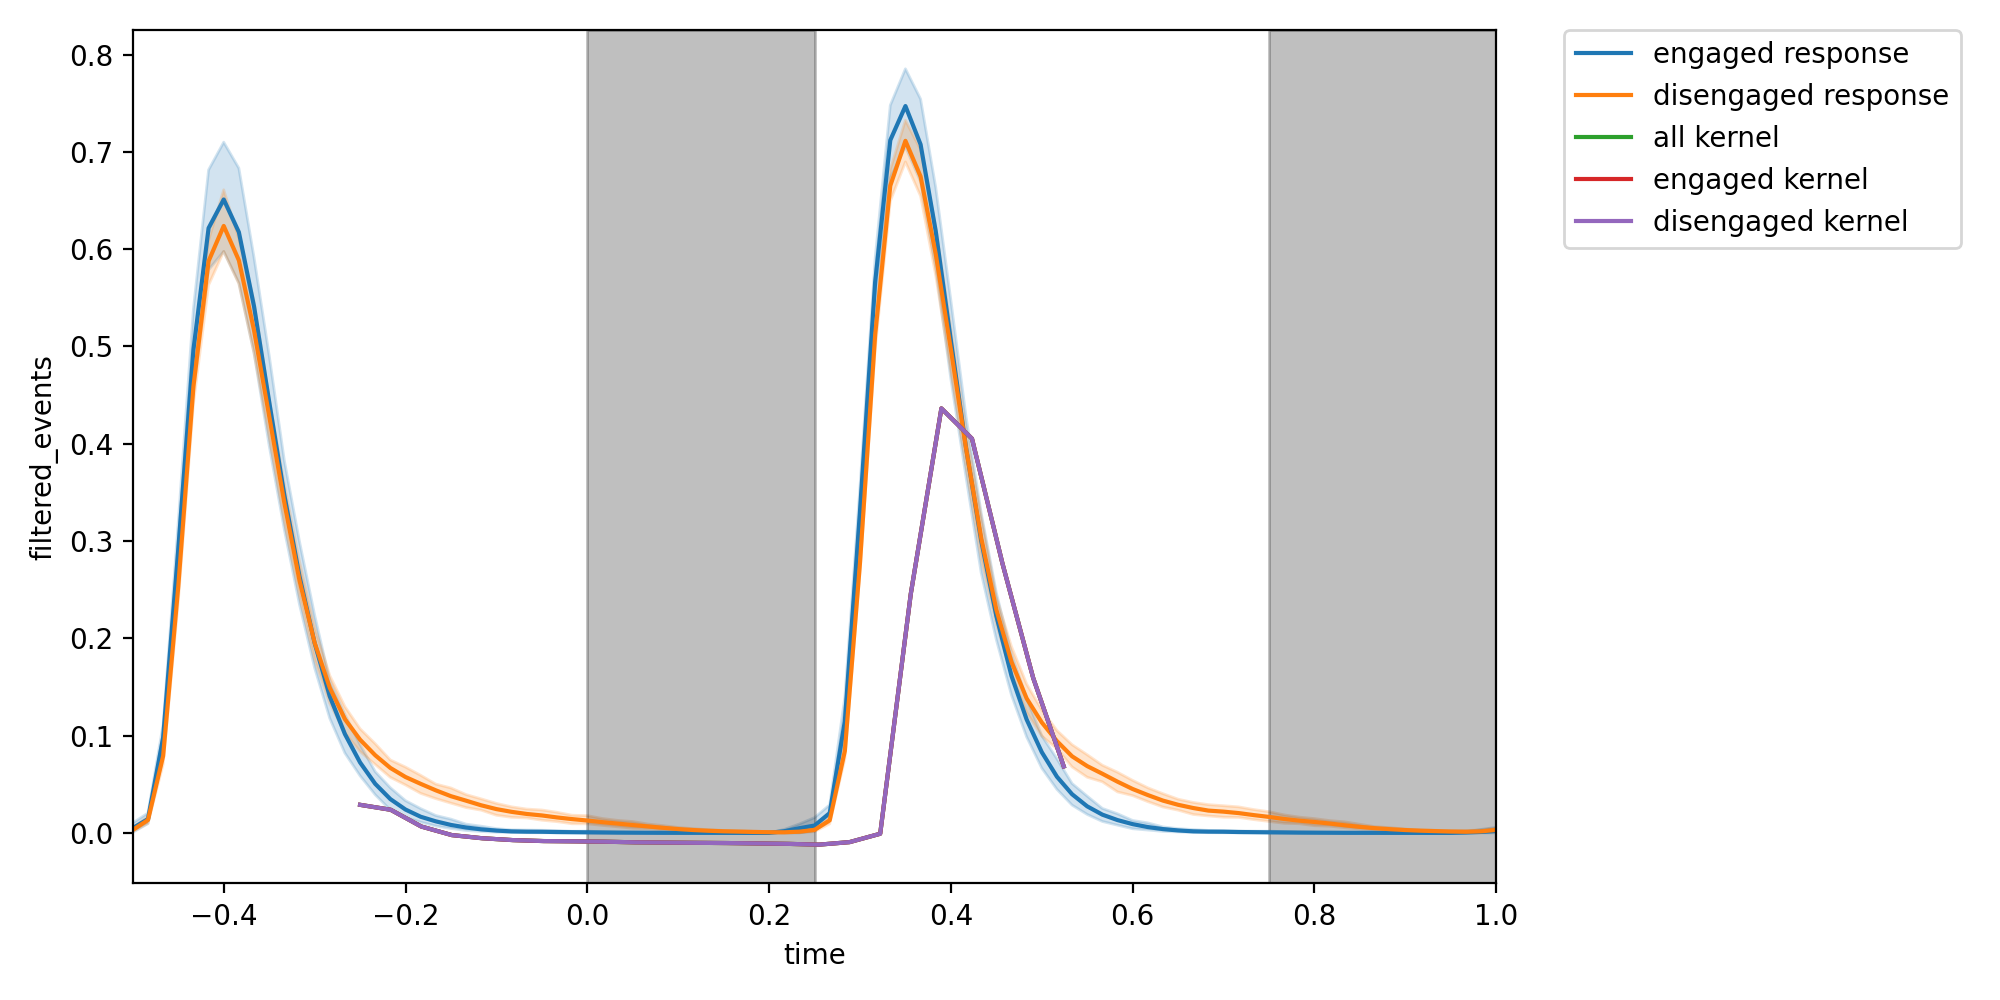

In [132]:
fig, ax = plt.subplots(figsize = (10,5))
for key in etrs.keys():
    sns.lineplot(
        data=etrs[key],
        x='time',
        y='filtered_events',
        n_boot=100,
        ax = ax
    )

ax.set_xlim(-0.5, 1)
for tstart in [0, 0.75, 1.5]:
    ax.axvspan(tstart, tstart+0.25, color='black',alpha=0.25)

legend_text = ['engaged response','disengaged response']

for e in ['all','engaged','disengaged']:
    glm =  models["16_events_{}_L2_optimize_by_session".format(e)]
    t, w = get_kernel_weights(glm, kernel_name='image6', cell_specimen_id=sample_cell['cell_specimen_id'])
    ax.plot(
        t,
        w_kernel,
    )
    legend_text.append('{} kernel'.format(e))
    
ax.legend(legend_text, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.tight_layout()

In [115]:
def get_kernel_weights(glm, kernel_name, cell_specimen_id):
    kernel_list = list(glm.design.kernel_dict.keys())
    all_weight_names = glm.X.weights.values

    t = np.linspace(
        0,
        glm.design.kernel_dict[kernel_name]['kernel_length_samples']/glm.fit['ophys_frame_rate'],
        glm.design.kernel_dict[kernel_name]['kernel_length_samples']
    )
    t += glm.design.kernel_dict[kernel_name]['offset_seconds']
    kernel_weight_names = [w for w in all_weight_names if w.startswith(kernel_name)]
    w_kernel = glm.W.loc[dict(weights=kernel_weight_names, cell_specimen_id=cell_specimen_id)]
    
    return t, w_kernel


In [121]:
glm =  models["16_events_all_L2_optimize_by_session"]
t, w1 = get_kernel_weights(glm, kernel_name='image6', cell_specimen_id=sample_cell['cell_specimen_id'])
print(w1)

<xarray.DataArray (weights: 24)>
array([ 3.47123281e-02,  3.97969063e-02,  2.40496073e-02,  1.57718534e-02,
        9.13399067e-03,  4.29206321e-03,  1.31711730e-03,  1.07195796e-05,
       -2.08911328e-03, -3.63865509e-03, -4.90580955e-03, -6.22623514e-03,
       -7.46945660e-03, -8.24963986e-03, -8.75986850e-03, -9.26174390e-03,
       -8.39092457e-03,  7.45175136e-04,  2.32985667e-01,  4.29217069e-01,
        3.96143908e-01,  2.78553744e-01,  1.63856507e-01,  7.68783652e-02])
Coordinates:
  * weights           (weights) <U19 'image6_-8' 'image6_-7' ... 'image6_15'
    cell_specimen_id  int64 1086505751


In [120]:
glm =  models["16_events_engaged_L2_optimize_by_session"]
t, w2 = get_kernel_weights(glm, kernel_name='image6', cell_specimen_id=sample_cell['cell_specimen_id'])
print(w2)

<xarray.DataArray (weights: 24)>
array([ 0.02883516,  0.02376259,  0.00654348, -0.00228796, -0.00554531,
       -0.00743964, -0.00842249, -0.00869217, -0.00906954, -0.00970636,
       -0.00995641, -0.01022328, -0.01045193, -0.01085   , -0.01129545,
       -0.0121041 , -0.00949601, -0.00089904,  0.24574164,  0.43634946,
        0.40524286,  0.27644867,  0.15931654,  0.06828881])
Coordinates:
  * weights           (weights) <U19 'image6_-8' 'image6_-7' ... 'image6_15'
    cell_specimen_id  int64 1086505751


In [124]:
glm =  models["16_events_disengaged_L2_optimize_by_session"]
t, w3 = get_kernel_weights(glm, kernel_name='image6', cell_specimen_id=sample_cell['cell_specimen_id'])
print(w3)

<xarray.DataArray (weights: 24)>
array([ 3.52901240e-02,  4.04482958e-02,  2.63500435e-02,  1.89403508e-02,
        1.20349033e-02,  6.85210626e-03,  3.62993931e-03,  2.17136115e-03,
       -2.00590071e-04, -1.94290715e-03, -3.46045367e-03, -5.01265081e-03,
       -6.48450383e-03, -7.36441669e-03, -7.96569085e-03, -8.51559879e-03,
       -8.29257580e-03,  2.93184871e-04,  2.13186515e-01,  3.97533635e-01,
        3.66020503e-01,  2.59192194e-01,  1.52922440e-01,  7.33589687e-02])
Coordinates:
  * weights           (weights) <U19 'image6_-8' 'image6_-7' ... 'image6_15'
    cell_specimen_id  int64 1086505751


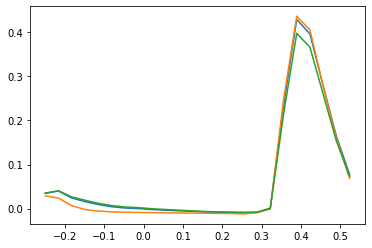

In [125]:
fig, ax = plt.subplots()
ax.plot(t, w1)
ax.plot(t, w2)
ax.plot(t, w3)